In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jieba.analyse
jieba.set_dictionary("jieba_dict/dict.txt.big")
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer

## Goal: Predict the number of sh of each article.

## Motivation(動機):

<img src="img/pathetic.png">



## Data Collection and Train/Validation/Test Split:


## Model Construction




$$N_a = T_a \times P_a$$

Where

$N_a$ is the numer of sh on the article a

$T_a$ is the total response of the article a

$P_a$ is the ratio of sh on the article a

會訓練兩個模型來分別預測這邊文章會有多少人回應($T_a$)以及這些回應有多少比例($P_a$)是噓文

## Exploratory Data Analysis

In [2]:
# Load the Data

content_data = pd.read_csv('crawlar/pttData.csv')
print(content_data.shape)

(3983, 7)


In [3]:
content_data.head()

,title,time,author,main_content,positive_push,negative_push,neutral_push
0,[新聞] 陸委會：紅色滲透媒體須另檢討 反滲透法,2019-12-27 14:20:55,作者zxcelephant (),\t1.媒體來源:\t中央社\t\t\t2.記者署名\t繆宗翰\t\t\t3.完整新聞標題:...,推 fromia: xddddddddddd 61.230.195.174 12/27 14...,噓 BlueBird5566: 蔡衍明的錢真有溫度 223.137.31.105 12/27...,→ Howard61313: 有沒有搞錯......... 115.82.10.90 1...
1,[新聞] 派遣歸零？台電200工程師年底失業,2019-12-27 14:26:52,作者notepad67 (甄姬拔劍),\t\t1.媒體來源:\t聯合報\t\t2.記者署名\t記者葉冠妤、戴瑞瑤／台北報導\t\t...,推 hipab: 樓下派遣工 程武 42.74.83.26 12/27 14:28\t...,噓 zxc17893: 派遣制度182.234.160.141 12/27 14:31\t噓...,→ sivhd: 三樓派遣肉便器 118.160.10.148 12/27 14:28\t→...
2,[新聞] 哈薩克貝克航空載有百人客機墜毀 已知9人,2019-12-27 14:28:27,作者LoserLHW (tototo),\t\t\t1.媒體來源:\t\t聯合報\t\t\t2.記者署名\t\t編譯徐榆涵\t\t\...,推 AllenHuang: 曾在我國的國華航空與華信航空服役 140.109.104.46 ...,噓 cp109: ..再反中阿 1.163.161.170 12/27 14:33\t,NaN
3,[新聞] 出生月與罹病相關？ 美研究：5月是健康寶,2019-12-27 14:33:31,作者GETpoint (擲雷爆卦),\t\t1.媒體來源:\t\t中時電子報 何立雯\t\t2.記者署名\t\t中時電子報 何立...,推 Israfil: 所以她食量很好啊 218.161.27.244 12/27 14:34...,噓 NTULioner: 又是統計學沒學好 39.10.203.42 12/27 14:...,→ peter0825: 難怪一直吃 36.230.205.142 12/27 14:34\...
4,[新聞] 韓女團成員從2.5公尺高舞台摔傷停工 SBS,2019-12-27 14:34:02,作者huangjyuan (Bryyuan),\t1.媒體來源:聯合報\t\t\t2.記者署名:王郁惠\t\t\t3.完整新聞標題:韓女團...,推 Workforme: 黑警去丟的 114.37.142.71 12/27 14:34\...,噓 kuo1102: 昨晚幫社長吹喇叭潛規則太累 180.17.217.233 12/2...,→ alex00089: 複製人沒差，下面一位 42.76.62.23 12/27 1...


## Naive estimation and Benchmark

In [4]:
# Create some numerical features and uses it as benchmark
# for single article
def count_push(txt):
    try:
        sh_list = txt.split('\t')
        return len(sh_list)-1
    except:
        return 0

content_data['sh_count'] = content_data['negative_push'].apply(count_push)
content_data['push_count'] = content_data['positive_push'].apply(count_push)
content_data['neutral_count'] = content_data['neutral_push'].apply(count_push)
content_data['total_count'] = content_data['push_count'] + content_data['neutral_count'] + content_data['sh_count']
content_data['sh_ratio'] = content_data['sh_count']/content_data['total_count']
content_data['title'] = content_data['title'].apply(lambda x: ''.join(x.split(' ')[1:]))
content_data['author'] = content_data['author'].apply(lambda x: x.split(' ')[0][2:])

步驟:
1. 清理標題(斷慈斷具)
2. tf-idf

In [5]:
# see the distribution of sh_count
train_data = content_data.iloc[-2400:]
validation_data = content_data.iloc[-3200:-2400]
test_data = content_data.iloc[:-3200]

In [6]:
print(train_data['sh_count'].mean())
print(validation_data['sh_count'].mean())
print(test_data['sh_count'].mean())

20.621666666666666
24.84625
22.343550446998723


In [7]:
#The benchmark estimation
benchmark_answer = np.array([train_data['sh_count'].mean()] * len(validation_data))
score = mean_absolute_error(validation_data['sh_count'].values,benchmark_answer)
print(score)

25.632012500000002


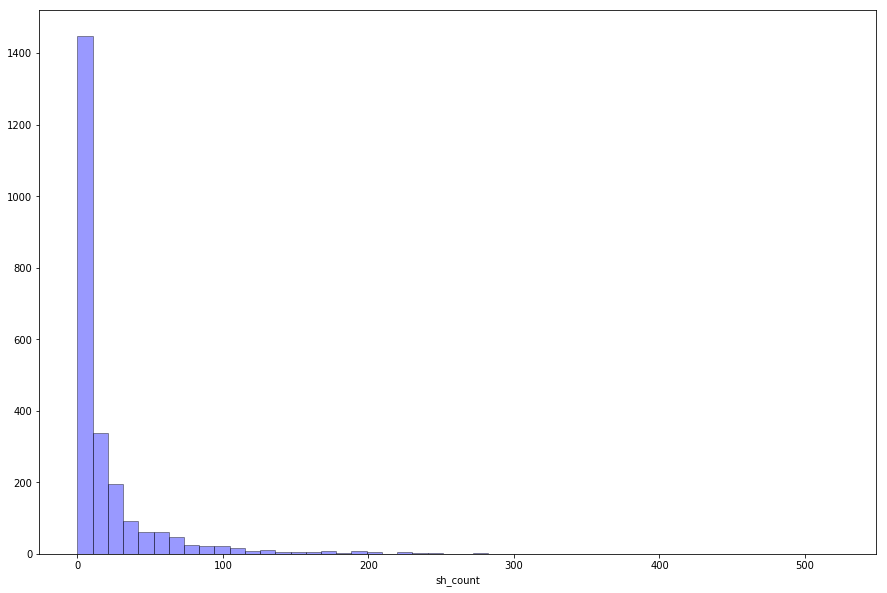

In [8]:
plt.figure(figsize=(15,10))
sns.distplot(train_data['sh_count'], hist=True, kde=False, 
              color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.show()

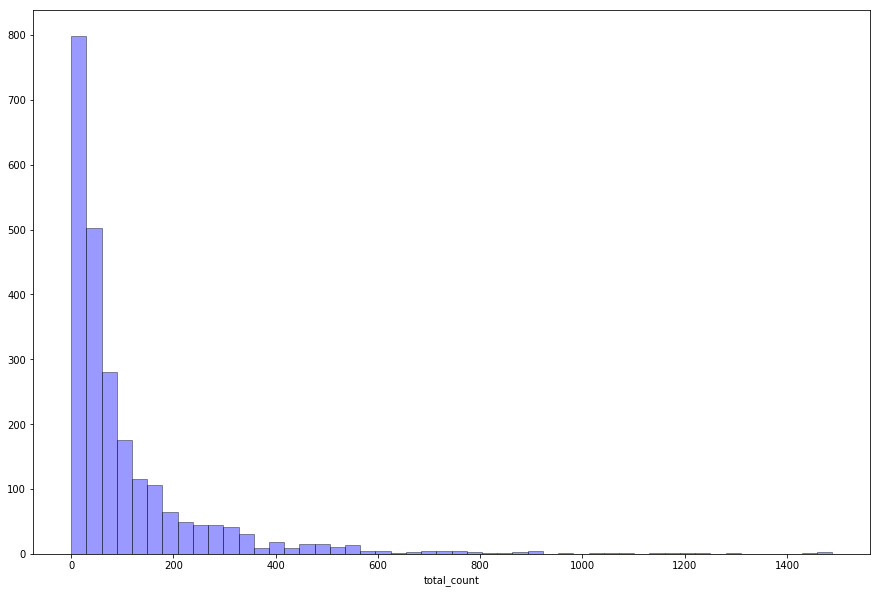

In [9]:
plt.figure(figsize=(15,10))
sns.distplot(train_data['total_count'], hist=True, kde=False, 
              color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.show()

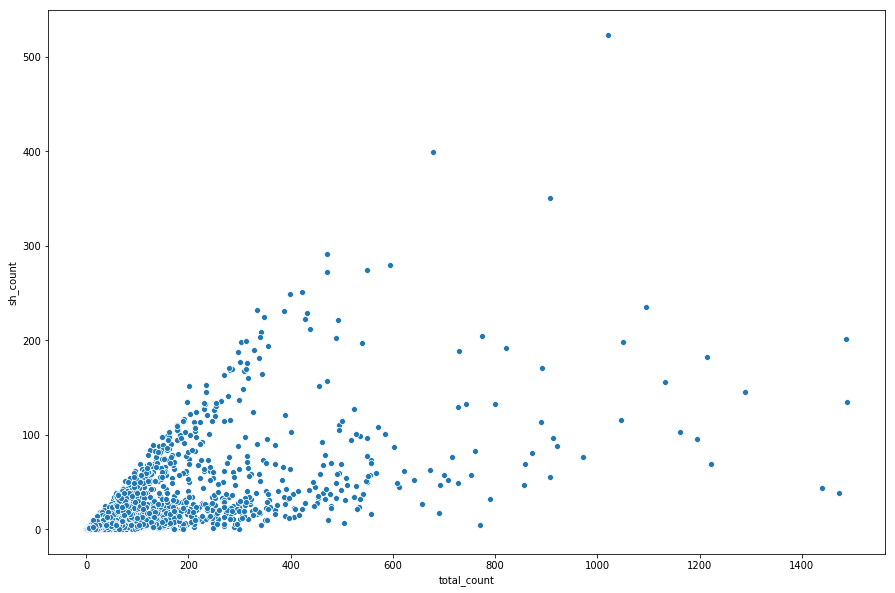

In [10]:
# The realation between total count and sh count

plt.figure(figsize=(15,10))
sns.scatterplot(train_data['total_count'], train_data['sh_count'])
plt.show()

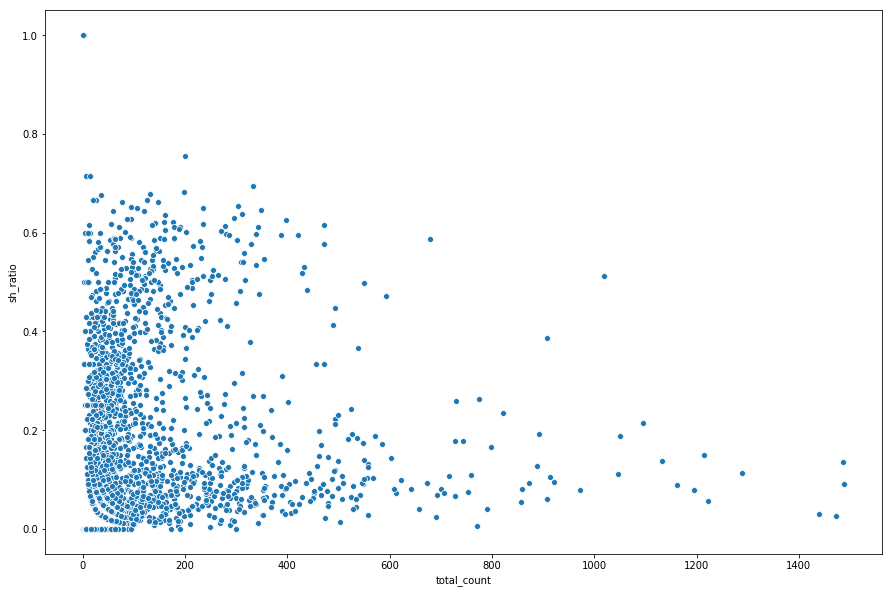

In [11]:
# The realation between total count and sh_ratio

plt.figure(figsize=(15,10))
sns.scatterplot(train_data['total_count'], train_data['sh_ratio'])
plt.show()

## Feature Engineer

In [12]:
# Contruct the feature for authors
print(train_data['author'] .head())
def compute_author(train_data):
    tmp_df = train_data.groupby('author')[['sh_ratio','total_count']].mean()
    tmp_df['sh_ratio_range']= pd.qcut(tmp_df['sh_ratio'],q=5,labels=[0,1,2,3,4])
    tmp_df['total_count_range'] = pd.qcut(tmp_df['total_count'],q=5,labels=[0,1,2,3,4])
    sh_ratio_dict = tmp_df[['sh_ratio_range']].to_dict(orient='index')
    total_count_dict = tmp_df[['total_count_range']].to_dict(orient='index')
    return sh_ratio_dict,total_count_dict

sh_ratio_dict,total_count_dict = compute_author(train_data)

1583      xianfen
1584    Eliphalet
1585    Workforme
1586     zzyyxx77
1587      wwf0322
Name: author, dtype: object


In [13]:
def fill_author_feat(datasets):
    for data in datasets:
        def fill_way(name,name_dict):
            try:
                return list(name_dict[name].values())[0]
            except:
                return 0
        data['sh_ratio_range'] = data['author'].apply(lambda x: fill_way(x,sh_ratio_dict))
        data['total_count_range'] = data['author'].apply(lambda x:fill_way(x,total_count_dict))

fill_author_feat([train_data,validation_data,test_data])

C:\Users\Qin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Qin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


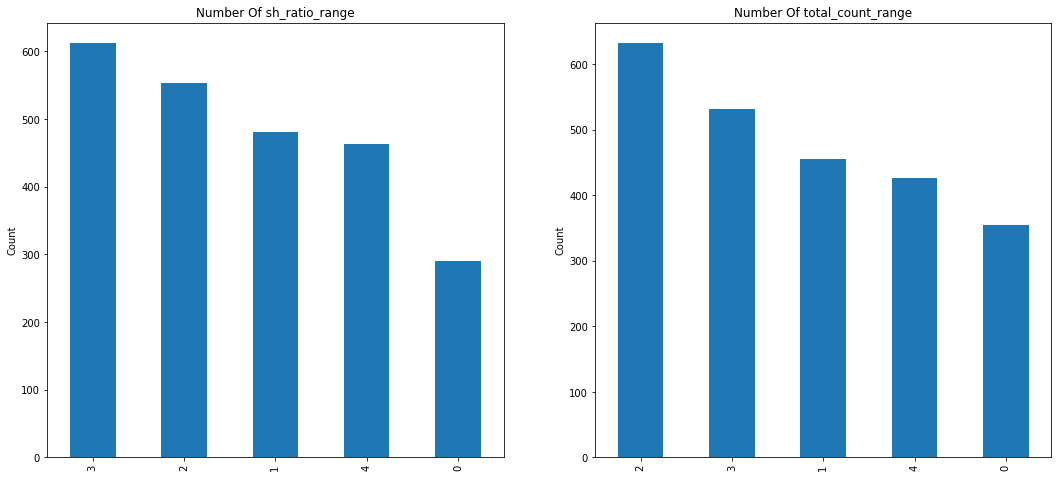

In [14]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train_data['sh_ratio_range'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number Of sh_ratio_range')
ax[0].set_ylabel('Count')
train_data['total_count_range'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('Number Of total_count_range')
ax[1].set_ylabel('Count')
plt.show()

0


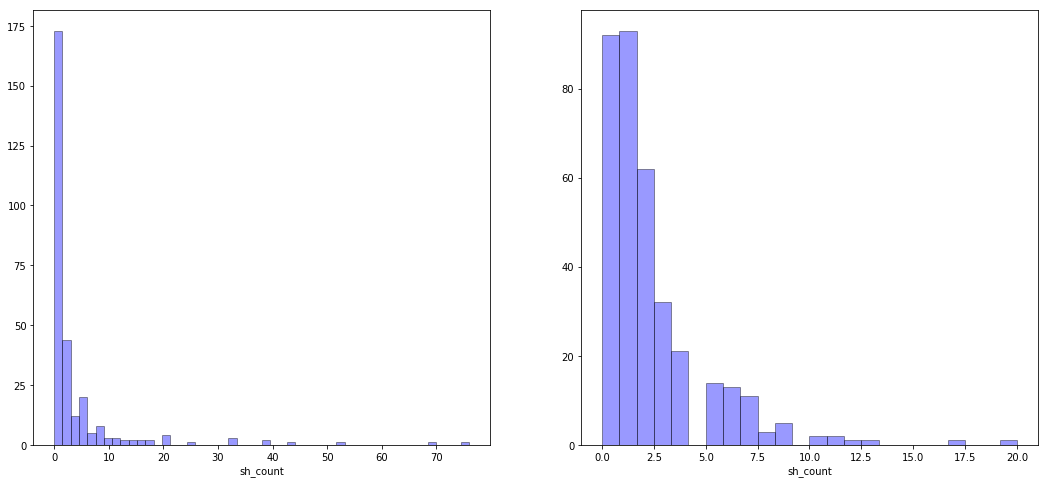

1


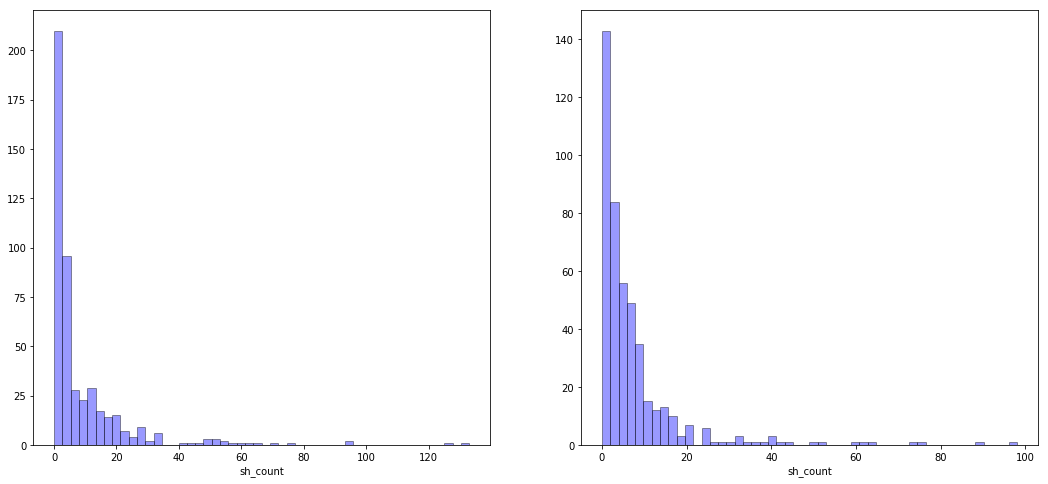

2


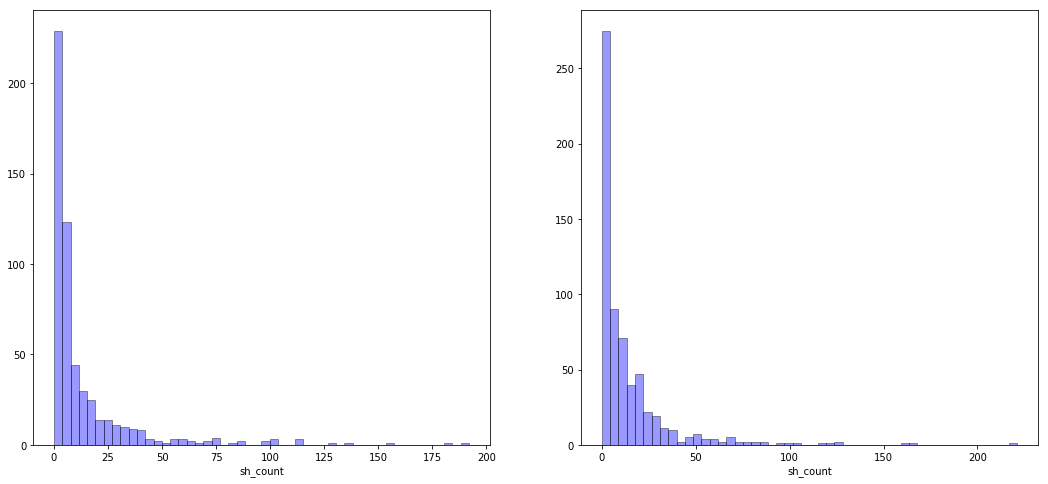

3


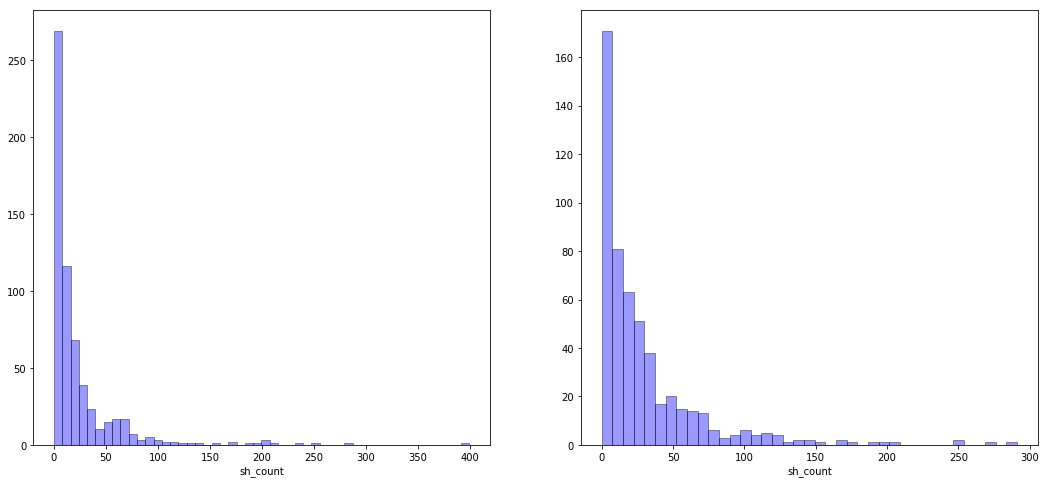

4


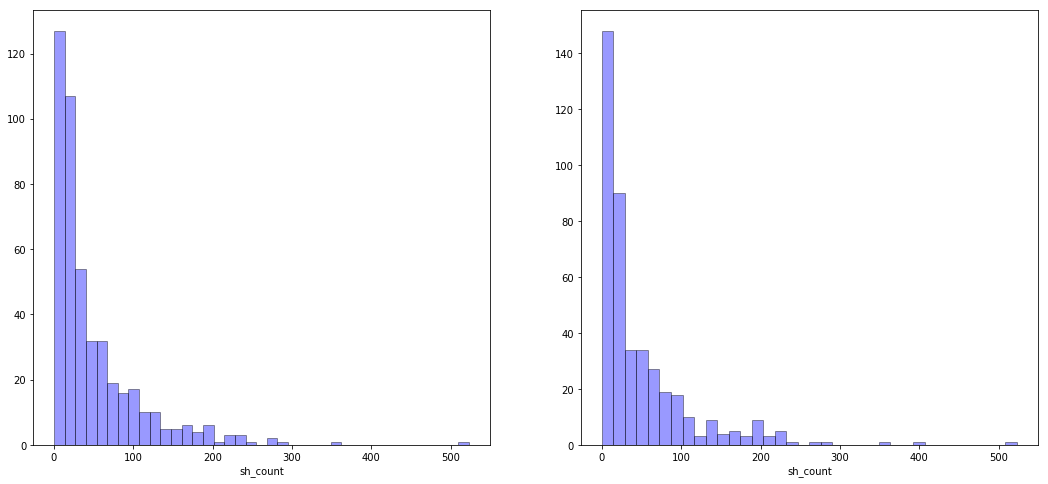

In [15]:
for idx in [0,1,2,3,4]:
    print(idx)
    f,ax=plt.subplots(1,2,figsize=(18,8))
    sns.distplot(train_data[train_data['sh_ratio_range']==idx]['sh_count'], hist=True, kde=False, 
                color = 'blue',
                hist_kws={'edgecolor':'black'},ax=ax[0])
    sns.distplot(train_data[train_data['total_count_range']==idx]['sh_count'], hist=True, kde=False, 
                color = 'blue',
                hist_kws={'edgecolor':'black'},ax=ax[1])
    plt.show()

0


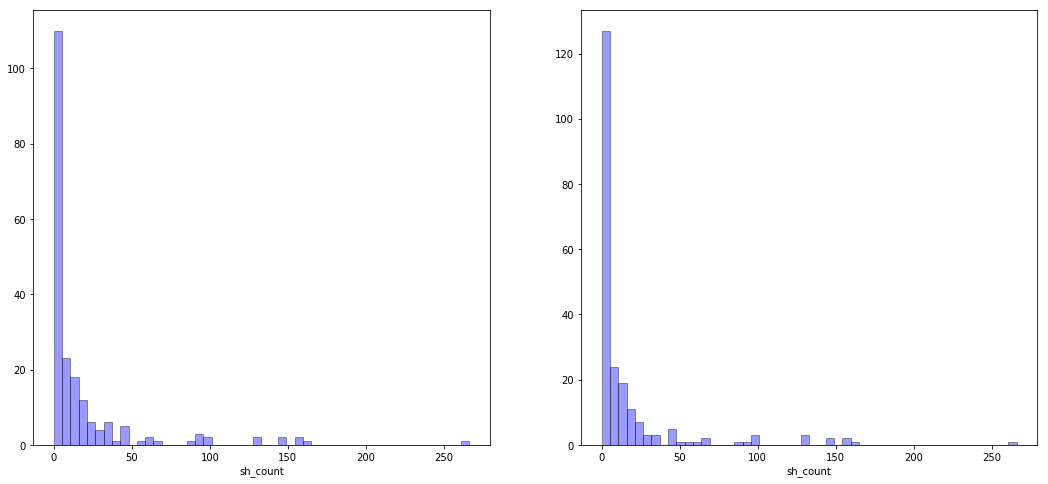

1


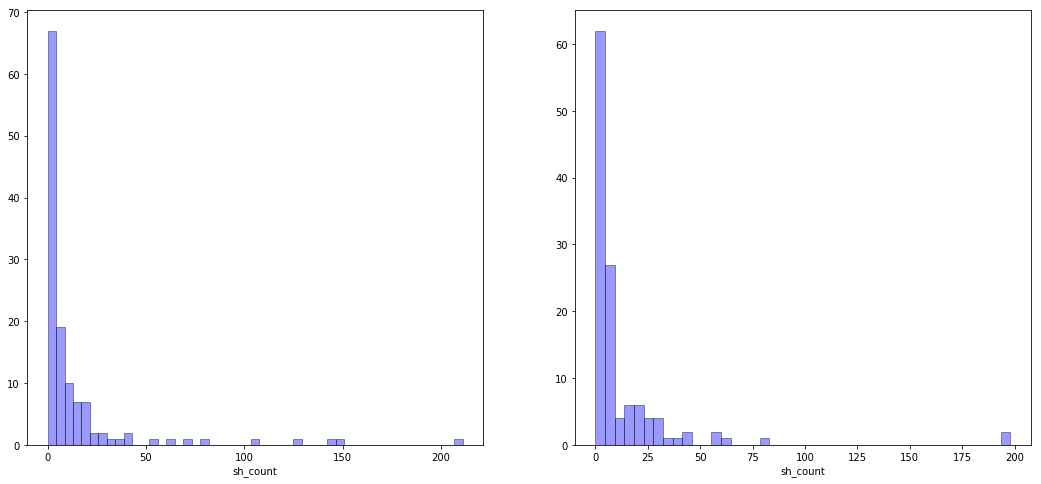

2


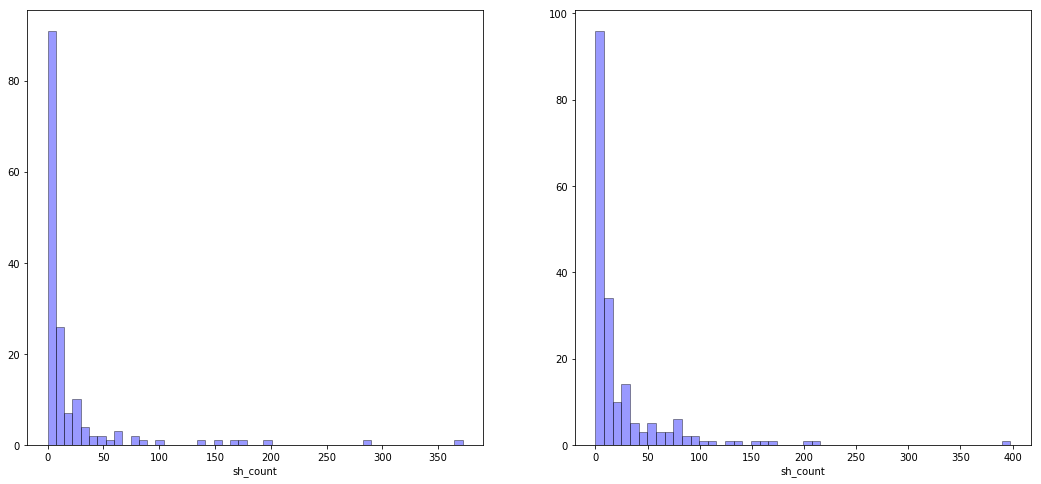

3


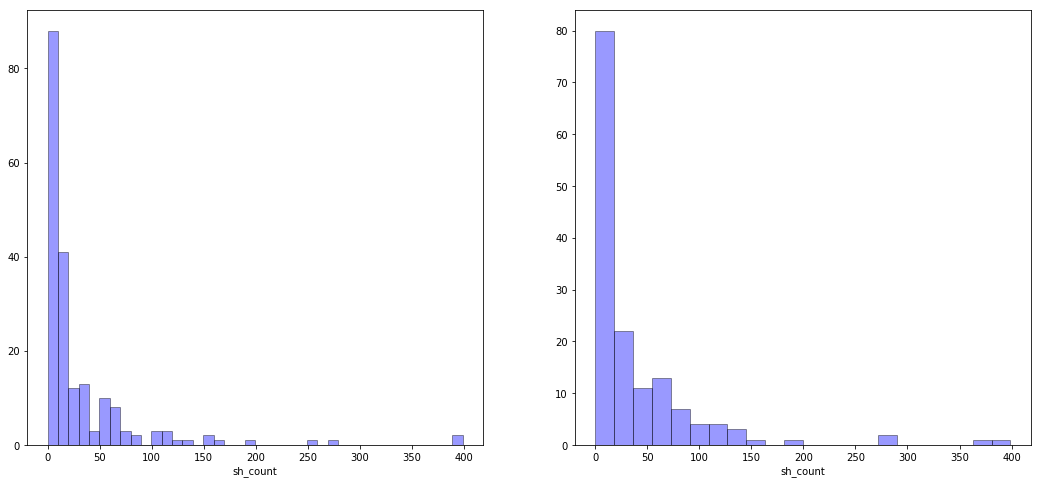

4


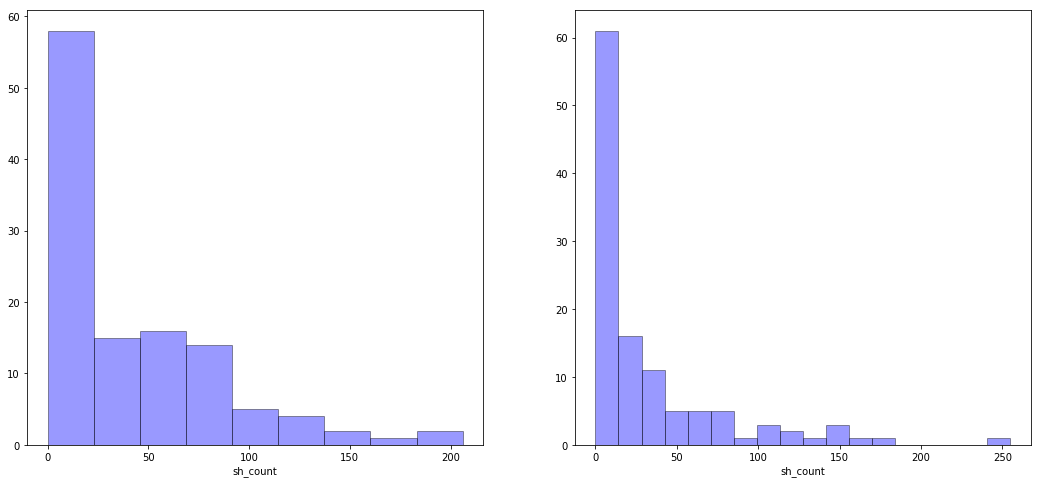

In [53]:
for idx in [0,1,2,3,4]:
    print(idx)
    f,ax=plt.subplots(1,2,figsize=(18,8))
    sns.distplot(validation_data[validation_data['sh_ratio_range']==idx]['sh_count'], hist=True, kde=False, 
                color = 'blue',
                hist_kws={'edgecolor':'black'},ax=ax[0])
    sns.distplot(validation_data[validation_data['total_count_range']==idx]['sh_count'], hist=True, kde=False, 
                color = 'blue',
                hist_kws={'edgecolor':'black'},ax=ax[1])
    plt.show()

In [ ]:
# Construct features for 

In [54]:
#Construct the Baseline model
from sklearn.ensemble import RandomForestRegressor

lables = train_data['sh_count']
features = train_data[['sh_ratio_range','total_count_range']]
reg = RandomForestRegressor()
reg.fit(features.values,lables.values)



C:\Users\Qin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [61]:
prediction = reg.predict(validation_data[['sh_ratio_range','total_count_range']].values)
score = mean_absolute_error(validation_data['sh_count'].values,prediction)
print(score)

23.398358343737296


In [16]:
# for title in train_data['title']:
#     print(title)
#     # tags = jieba.analyse.extract_tags(title,10)
#     tags = jieba.cut(title)
#     # print(tags)
#     print([tag for tag in tags])
#     # print(",".join(tags))